<a href="https://colab.research.google.com/github/MariaGeorgiou/MariaGeorgiou/blob/main/Applied_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
%%capture

!pip install category_encoders==2.*

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, \
    RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving student.csv to student.csv


In [ ]:
df=pd.read_csv("student.csv")

In [ ]:
df.head()

,Unnamed: 0,Id,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,0,5001,21,Male,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,1,5002,20,Male,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,2,5003,21,Male,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,3,5004,18,Female,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,4,5005,22,Male,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


In [ ]:
def wrangle(filepath):

    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath)

    # Drop constant columns
    df.drop(columns=['Id'], inplace=True)

    if df.columns[0].startswith('Unnamed:'):
      df = df.iloc[:, 1:]


    # Create age feature
    df['Top Grade'] = (df['Grade'] == 'AA').astype(int)
    df.drop(columns=['Grade'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)


    return df

In [ ]:
df = wrangle('student.csv')


df.head(10)

,Student_Age,Sex,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Top Grade
0,21,Male,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,1
1,20,Male,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,1
2,21,Male,State,50%,No,No,Private,2,Never,No,No,No,Yes,1
3,18,Female,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,1
4,22,Male,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,1
5,20,Male,State,50%,No,No,Private,2,Always,Yes,No,Yes,Yes,0
6,18,Male,State,75%,No,No,Private,0,Always,No,Yes,Yes,Yes,0
7,18,Female,State,50%,Yes,Yes,Bus,2,Sometimes,No,Yes,Yes,Yes,0
8,19,Female,Other,50%,No,Yes,Bus,0,Always,No,No,No,Yes,0
9,21,Female,State,50%,No,No,Bus,12,Never,No,Yes,No,No,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Student_Age         145 non-null    int64 
 1   Sex                 145 non-null    object
 2   High_School_Type    145 non-null    object
 3   Scholarship         145 non-null    object
 4   Additional_Work     145 non-null    object
 5   Sports_activity     145 non-null    object
 6   Transportation      145 non-null    object
 7   Weekly_Study_Hours  145 non-null    int64 
 8   Attendance          145 non-null    object
 9   Reading             145 non-null    object
 10  Notes               145 non-null    object
 11  Listening_in_Class  145 non-null    object
 12  Project_work        145 non-null    object
 13  Top Grade           145 non-null    int64 
dtypes: int64(3), object(11)
memory usage: 16.0+ KB


In [ ]:
target = 'Top Grade'
y = df[target]
X = df.drop(target, axis=1)

<Axes: >

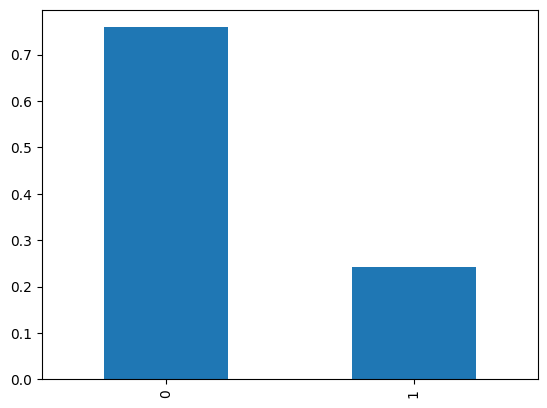

In [ ]:
y.value_counts(normalize=True).plot(kind='bar')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

In [ ]:
X_train.shape, X_val.shape

((116, 13), (29, 13))

In [ ]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.7241379310344828


In [ ]:
model_lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(), #used only for linear models - not tree based models.
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'), #(nan values)
    RandomForestClassifier(random_state=42, n_jobs=-1) #model class - can also use for regression, n_jobs- how many cores to use

)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Sex', 'High_School_Type', 'Scholarship',
                                      'Additional_Work', 'Sports_activity',
                                      'Transportation', 'Attendance', 'Reading',
                                      'Notes', 'Listening_in_Class',
                                      'Project_work'],
                                mapping=[{'col': 'Sex', 'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'High_School_Type',
                                          'data_type': dtype('O'),
                                          '...
                                         {'col': 'Notes',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
6      3
NaN   -2
dtype: int64},
                                         {'col': 'Listening_in_Class',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64},
                                         {'col': 'Project_work',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.7413793103448276
Validation Accuracy (LOGR): 0.7241379310344828


In [ ]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.7586206896551724


In [ ]:


print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.00      0.00      0.00         3

    accuracy                           0.72        29
   macro avg       0.44      0.40      0.42        29
weighted avg       0.78      0.72      0.75        29



In [ ]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.00      0.00      0.00         3

    accuracy                           0.76        29
   macro avg       0.44      0.42      0.43        29
weighted avg       0.79      0.76      0.77        29



In [ ]:
# Gradient Boosted Model

model_gb= make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=75)

)

model_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Sex', 'High_School_Type', 'Scholarship',
                                      'Additional_Work', 'Sports_activity',
                                      'Transportation', 'Attendance', 'Reading',
                                      'Notes', 'Listening_in_Class',
                                      'Project_work'],
                                mapping=[{'col': 'Sex', 'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'High_School_Type',
                                          'data_type': dtype('O'),
                                          '...
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
6      3
NaN   -2
dtype: int64},
                                         {'col': 'Listening_in_Class',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64},
                                         {'col': 'Project_work',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=75, random_state=42))])

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)


model_xgb= make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1)

)

model_xgb.fit(X_train, y_train_encoded)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Sex', 'High_School_Type', 'Scholarship',
                                      'Additional_Work', 'Sports_activity',
                                      'Transportation', 'Attendance', 'Reading',
                                      'Notes', 'Listening_in_Class',
                                      'Project_work'],
                                mapping=[{'col': 'Sex', 'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'High_School_Type',
                                          'data_type': dtype('O'),
                                          '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=75, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 1.0
Validation Accuracy 0.7586206896551724


In [ ]:
print('Training Accuracy', model_gb.score(X_train, y_train))
print('Validation Accuracy', model_gb.score(X_val, y_val))

Training Accuracy 0.9655172413793104
Validation Accuracy 0.5862068965517241


In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train_encoded))
print('Validation Accuracy', model_xgb.score(X_val, y_val_encoded))

Training Accuracy 0.9913793103448276
Validation Accuracy 0.6551724137931034


Text(0, 0.5, 'Feature')

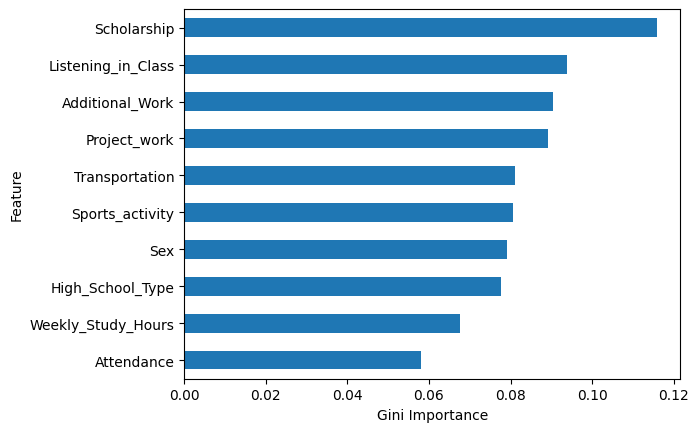

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [ ]:
column_to_permute = 'Scholarship'

# Step 2: Train model w/ ALL features
model_to_permute = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_to_permute.fit(X_train, y_train_encoded);

In [ ]:
# Step 3: Evaluate model using VALIDATION DATA.
print('Validation Accuracy', model_to_permute.score(X_val, y_val_encoded))

Validation Accuracy 0.6551724137931034


In [ ]:
# Step 4: In VALIDATION DATA, permute the feature we're evaluating
X_val_perm = X_val.copy()
X_val_perm[column_to_permute]= np.random.permutation(X_val_perm[column_to_permute])

In [ ]:
# Step 5: Calculate our error metric with the permuted data
print('Validation Accuracy', model_to_permute.score(X_val_perm, y_val_encoded))

Validation Accuracy 0.7241379310344828


In [ ]:
# Automated using sklearn

from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_to_permute, X_val, y_val_encoded, random_state=42)

In [ ]:
perm_imp

{'importances_mean': array([-6.89655172e-03, -2.75862069e-02,  3.44827586e-02, -4.44089210e-17,
        -2.06896552e-02,  6.20689655e-02, -6.89655172e-03, -1.37931034e-02,
         6.89655172e-03, -4.13793103e-02,  6.89655172e-03, -4.82758621e-02,
        -2.06896552e-02]),
 'importances_std': array([0.0137931 , 0.04574655, 0.02180881, 0.04361762, 0.03516565,
        0.04021346, 0.02580453, 0.03516565, 0.02580453, 0.02580453,
        0.0137931 , 0.01689303, 0.02758621]),
 'importances': array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.03448276],
        [-0.03448276,  0.03448276, -0.10344828,  0.        , -0.03448276],
        [ 0.03448276,  0.        ,  0.06896552,  0.03448276,  0.03448276],
        [-0.03448276, -0.06896552,  0.03448276,  0.03448276,  0.03448276],
        [-0.06896552,  0.        , -0.03448276,  0.03448276, -0.03448276],
        [ 0.        ,  0.10344828,  0.06896552,  0.03448276,  0.10344828],
        [-0.03448276,  0.        ,  0.03448276, -0.03448276

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
Listening_in_Class,-4.827586e-02,0.016893
Reading,-4.137931e-02,0.025805
Sex,-2.758621e-02,0.045747
Project_work,-2.068966e-02,0.027586
Additional_Work,-2.068966e-02,0.035166
Weekly_Study_Hours,-1.379310e-02,0.035166
Transportation,-6.896552e-03,0.025805
Student_Age,-6.896552e-03,0.013793
Scholarship,-4.440892e-17,0.043618
Attendance,6.896552e-03,0.025805


<Axes: >

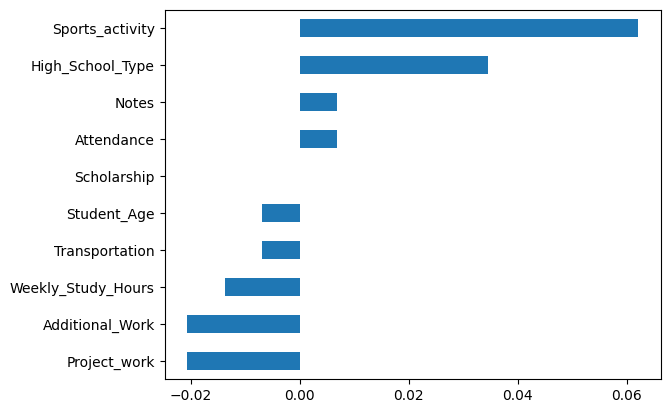

In [ ]:
df_perm['imp_mean'].tail(10).plot(kind='barh')
